**Telco Churn – Gün 6: Model İyileştirme**

In [ ]:
#kurulum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
)
from imblearn.over_sampling import SMOTE

plt.style.use("ggplot")
sns.set_palette("pastel")

print("✅ Gün 6 ortamı hazır!")


✅ Gün 6 ortamı hazır!


In [15]:
from google.colab import files
files.upload()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
df=pd.read_csv("cleaned_telco_churn.csv")
df.head()
X=df.drop(columns=["Churn"])
y=df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


print("Eğitim veri boyutu:", X_train.shape)
print("Churn oranı(önce)")
print(y_train.value_counts(normalize=True))

In [ ]:
# 2) SMOTE İLE VERİ DENGELEME
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Churn orani(sonra):")
print(y_train_res.value_counts(normalize=True))

In [ ]:

# 3) ÖLÇEKLEME (SCALING)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print("✅ Veriler ölçeklendi.")


In [ ]:

# 4) GRIDSEARCHCV İLE HİPERPARAMETRE OPTİMİZASYONU

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    rf, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1
)
grid_search.fit(X_train_scaled, y_train_res)

print("🏁 En iyi parametreler:")
print(grid_search.best_params_)
print(f"En iyi F1 skoru: {grid_search.best_score_:.3f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
🏁 En iyi parametreler:
{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
En iyi F1 skoru: 0.837


In [ ]:

# 5) EN İYİ MODELİ TEST SETİNDE DEĞERLENDİR

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:,1]

print("🔎 Model Performansı (Test Verisi):")
print(classification_report(y_test, y_pred, digits=3))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


🔎 Model Performansı (Test Verisi):
              precision    recall  f1-score   support

           0      0.875     0.785     0.827      1035
           1      0.536     0.690     0.604       374

    accuracy                          0.759      1409
   macro avg      0.706     0.737     0.715      1409
weighted avg      0.785     0.759     0.768      1409

ROC-AUC: 0.833


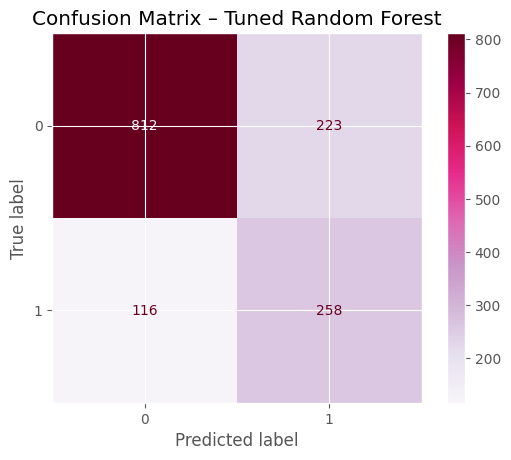

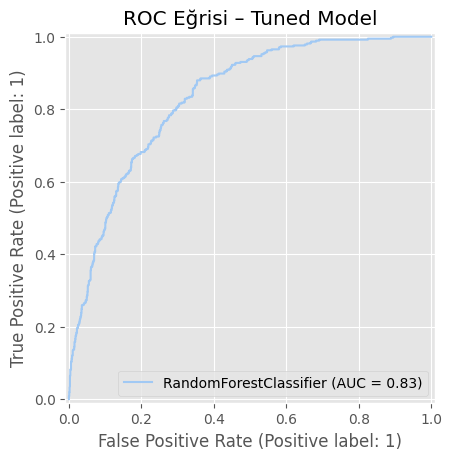

In [ ]:

# 6) ROC EĞRİSİ & KARMAŞA MATRİSİ

ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test, cmap="PuRd")
plt.title("Confusion Matrix – Tuned Random Forest")
plt.show()

RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.title("ROC Eğrisi – Tuned Model")
plt.show()


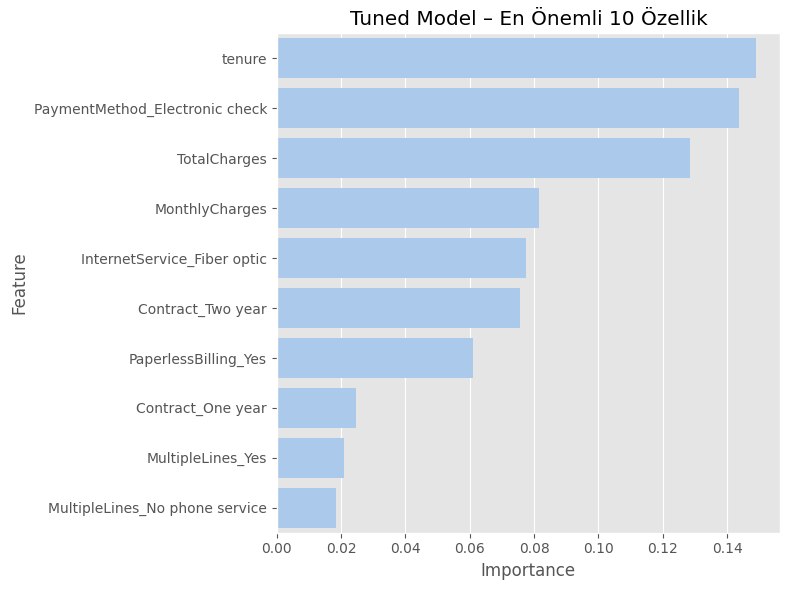

In [16]:

# 7) EN ÖNEMLİ ÖZELLİKLER (FEATURE IMPORTANCE)

feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(10))
plt.title("Tuned Model – En Önemli 10 Özellik")
plt.tight_layout()
plt.show()


In [17]:

# 8) MODELİ KAYDET

import joblib
joblib.dump(best_model, "best_model_day6_tuned.pkl")
joblib.dump(scaler, "scaler_day6.pkl")
print("✅ Tuned model ve scaler kaydedildi.")


✅ Tuned model ve scaler kaydedildi.
